<a href="https://colab.research.google.com/github/EpicOne1/7318-Deep-Learning/blob/master/VGG11_C.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
device

device(type='cuda', index=0)

In [5]:
transform = transforms.Compose([
    transforms.ToTensor(),  
    transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [7]:
import torch.nn as nn
import torch.nn.functional as F

# VGG11 ConvNet configuration is 'A', 'M' = Max pooling layer
# B is reduced size networks 
cfgs = {'C': [64, 'M', 128, 'M', 256, 256, 'M']}

def make_layers(cfg):
    layers = []
    in_channels = 3
    for v in cfg:
        if v == 'M':
            layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
        else: 
            # add convolutional layer and Batch Norm
            layers.append(nn.Conv2d(in_channels=in_channels,
                                    out_channels=v,
                                    kernel_size=3,
                                    stride=1,
                                    padding=1,
                                    bias=True))
            layers.append(nn.BatchNorm2d(v))
            layers.append(nn.ReLU(inplace=True))
            in_channels = v
    return nn.Sequential(*layers)



class VGG(nn.Module):
    # 10 classes
    def __init__(self, name, num_classes=10):
        super(VGG, self).__init__()
        # VGG11
        cfg = cfgs[name]
        self.layers = make_layers(cfg)
        self.avgpool = nn.AdaptiveAvgPool2d((3,3)) # change 7x7 to 3x3
        self.classifier = nn.Sequential(
            nn.Linear(256*3*3, 512), #fc1
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(512,256), #fc2
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(256, num_classes) #fc3
        )
            
    def forward(self,x):
        x = self.layers(x)
        x = self.avgpool(x)
        x = torch.flatten(x,1)
        x = self.classifier(x)
        return x
    
def VGG11_C():
  return VGG('C')

    
net = VGG11_C().to(device)
print(net)

VGG(
  (layers): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): ReLU(inplace=True)
    (14): MaxPool2d(kern

In [10]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr = 0.001, momentum=0.9)

In [11]:
training_acc = []
test_acc = []
train_loss = []

for epoch in range(20): # loop over the dataset 20 times (1 epoch = all training samples)
    
    running_loss = 0.0
    # ith mini-batch, 1 mini-batch has 64 training samples 
    # batch size = 64
    for i, data in enumerate(trainloader, 0):
        # get inputs; the data is presented as a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        # zero the parameter gradients
        optimizer.zero_grad()
        
        # forward 
        outputs = net(inputs)
        # calculate loss
        loss = criterion(outputs, labels)
        # backward
        loss.backward()
        # update parameter (optimize)
        optimizer.step()
        
        # print statistics
        running_loss += loss.item()
        if i%125 == 124: # print every 125 mini-batches, 125*64 samples
            print('[%d, %5d] loss: %.3f' %
                 (epoch+1, i+1, running_loss/125))
            # every 125 mini-batches, reset running_loss    
            # because it is accumulated for each mini-batches
            train_loss.append(running_loss/125)
            running_loss = 0.0
            
    
    # training and test accuracy for each epoch
    # train
    correct = 0
    total = 0
    # no_grad(): reduce memory consumption for computations
    with torch.no_grad():
        # load data from training set
        for data in trainloader:
            images, labels = data
            images = images.to(device)
            labels = labels.to(device)
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        training_acc.append(100 * correct / total)
        
    # test     
    correct = 0
    total = 0
    # no_grad(): reduce memory consumption for computations
    with torch.no_grad():
        # load data from test set
        for data in testloader:
            images, labels = data
            images = images.to(device)
            labels = labels.to(device)
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        test_acc.append(100 * correct / total)    
        
print("Finished Training")

[1,   125] loss: 2.206
[1,   250] loss: 1.931
[1,   375] loss: 1.765
[1,   500] loss: 1.667
[1,   625] loss: 1.545
[1,   750] loss: 1.461
[2,   125] loss: 1.391
[2,   250] loss: 1.338
[2,   375] loss: 1.287
[2,   500] loss: 1.254
[2,   625] loss: 1.225
[2,   750] loss: 1.203
[3,   125] loss: 1.122
[3,   250] loss: 1.090
[3,   375] loss: 1.095
[3,   500] loss: 1.063
[3,   625] loss: 1.059
[3,   750] loss: 1.000
[4,   125] loss: 0.961
[4,   250] loss: 0.942
[4,   375] loss: 0.940
[4,   500] loss: 0.923
[4,   625] loss: 0.920
[4,   750] loss: 0.904
[5,   125] loss: 0.857
[5,   250] loss: 0.824
[5,   375] loss: 0.840
[5,   500] loss: 0.815
[5,   625] loss: 0.835
[5,   750] loss: 0.819
[6,   125] loss: 0.750
[6,   250] loss: 0.746
[6,   375] loss: 0.745
[6,   500] loss: 0.742
[6,   625] loss: 0.747
[6,   750] loss: 0.749
[7,   125] loss: 0.700
[7,   250] loss: 0.676
[7,   375] loss: 0.690
[7,   500] loss: 0.676
[7,   625] loss: 0.668
[7,   750] loss: 0.669
[8,   125] loss: 0.627
[8,   250] 

VGG11_C

In [12]:
training_acc

[47.428,
 57.482,
 65.2,
 70.214,
 73.07,
 76.564,
 78.924,
 81.348,
 82.244,
 83.336,
 84.962,
 86.106,
 88.284,
 89.26,
 91.386,
 92.08,
 93.466,
 92.674,
 94.94,
 95.674]

In [13]:
test_acc

[47.12,
 55.98,
 63.9,
 68.06,
 70.45,
 72.35,
 73.88,
 75.35,
 76.05,
 76.41,
 77.34,
 76.72,
 78.77,
 77.94,
 79.72,
 79.12,
 79.64,
 78.08,
 79.02,
 80.19]

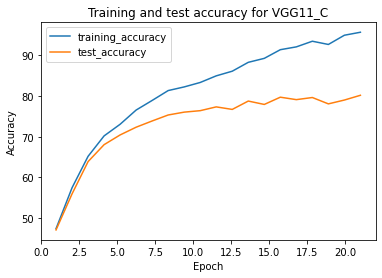

In [14]:
import matplotlib.pyplot as plt
import numpy as np
epoch = np.linspace(1,21,20)
fig = plt.figure()
plt.plot(epoch, training_acc, label = 'training_accuracy')
plt.plot(epoch, test_acc, label = 'test_accuracy')
plt.title('Training and test accuracy for VGG11_C')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
fig.savefig('VGG11_C_result.jpg')